In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load
import gc

In [2]:
data_bs1 = pd.read_csv('../data/preprocessed_data_BS1.csv')
data_bs1.head()

,hg38_ASF1A,hg38_CCT7,hg38_EPOR,hg38_NECAP2,hg38_LRRC8A,hg38_NDUFS8,hg38_MRPL22,hg38_HIST1H2BC,hg38_LY96,hg38_UBE2E2-AS1,...,hg38_TMEM128,hg38_ASPSCR1,hg38_CDC20,hg38_DNAJB9,hg38_OSTM1,hg38_LCNL1,hg38_PHB,hg38_LRRC29,hg38_ZFP36,Group
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
1,0,0,0,3,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,2,0,3,B
3,0,0,0,0,0,3,0,0,0,0,...,0,0,0,3,0,0,3,0,0,B
4,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B


In [3]:
data_bs2 = pd.read_csv('../data/preprocessed_data_BS2.csv')
data_geo = pd.read_csv('../data/preprocessed_data_GEO.csv')
data_10x = pd.read_csv('../data/preprocessed_data_10x.csv')

In [4]:
X = data_bs1.drop(['Group'], axis=1)
y = data_bs1['Group']

In [5]:
def replace_values(y):
    return y.replace({'B': 0, 'D': 1, 'M': 2, 'NK': 3, 'T': 4}, regex=True)

In [6]:
encoded_y = replace_values(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [9]:
def model_info(y_real, y_pred, labels=['B', 'D', 'M', 'NK', 'T']):
    cm = confusion_matrix(y_real, y_pred)
    class_sums = cm.sum(axis=1)
    normalized_conf_matrix = cm / class_sums[:, np.newaxis]
    sns.heatmap(normalized_conf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
    plt.xlabel('Predvidjene vrednosti')
    plt.ylabel('Stvarne vrednosti')
    plt.title('Matrica konfuzije')
    plt.show()

    print('Matrica konfuzije: \n', cm)
    print('Accuracy score: ', accuracy_score(y_real, y_pred))
    print('Precision score: ', precision_score(y_real, y_pred, average='weighted', zero_division=0))
    print('Recall score: ', recall_score(y_real, y_pred, average='weighted'))
    print('F1 score: ', f1_score(y_real, y_pred, average='weighted'))

In [10]:
def build_model(model, X_train, X_test, y_train, y_test, classes=['B', 'D', 'M', 'NK', 'T']):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    model_info(y_test, y_pred, classes)

    return model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [12]:
best_params_rf = {
    'max_depth': 15,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 300
}

best_params_xgb = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'n_estimators': 300
}

best_params_lr = {
    'C': 0.001,
    'penalty': 'l2',
    'solver': 'sag',
}

best_params_mlp = {
    'alpha': 1e-05,
    'batch_size': 32,
    'hidden_layer_sizes': (50,),
    'learning_rate_init': 0.001,
    'max_iter': 1000
}

In [13]:
model_rf = RandomForestClassifier(**best_params_rf, random_state=55)
model_xgb = XGBClassifier(**best_params_xgb, random_state=55)
model_lr = LogisticRegression(**best_params_lr, random_state=55)
model_mlp = MLPClassifier(**best_params_mlp, random_state=55)

In [14]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=300,
                       random_state=55)

In [15]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [16]:
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.001, random_state=55, solver='sag')

In [17]:
model_mlp.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, batch_size=32, hidden_layer_sizes=(50,),
              max_iter=1000, random_state=55)

In [60]:
RF = 0
XGB = 1
LR = 2
MLP = 3

predictions = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

cms = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

accuracy = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}
precision = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}
recall = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}
f1 = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

In [61]:
def evaluate_model(model, X_test, y_test, model_name, data_name):
    y_pred = model.predict(X_test)

    predictions[data_name][model_name] = y_pred
    cms[data_name][model_name] = confusion_matrix(y_test, y_pred)

    accuracy[data_name][model_name] = accuracy_score(y_test, y_pred)
    precision[data_name][model_name] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall[data_name][model_name] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1[data_name][model_name] = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    return model

In [62]:
evaluate_model(model_rf, X_test, y_test, RF, 'bs1')
evaluate_model(model_xgb, X_test, y_test, XGB, 'bs1')
evaluate_model(model_lr, X_test, y_test, LR, 'bs1')
evaluate_model(model_mlp, X_test, y_test, MLP, 'bs1')

MLPClassifier(alpha=1e-05, batch_size=32, hidden_layer_sizes=(50,),
              max_iter=1000, random_state=55)

In [63]:
X = data_bs2.drop(['Group'], axis=1)
y = data_bs2['Group']
encoded_y = replace_values(y)

evaluate_model(model_rf, X, encoded_y, RF, 'bs2')
evaluate_model(model_xgb, X, encoded_y, XGB, 'bs2')
evaluate_model(model_lr, X, encoded_y, LR, 'bs2')
evaluate_model(model_mlp, X, encoded_y, MLP, 'bs2')

MLPClassifier(alpha=1e-05, batch_size=32, hidden_layer_sizes=(50,),
              max_iter=1000, random_state=55)

In [64]:
X = data_geo.drop(['Group'], axis=1)
y = data_geo['Group']
encoded_y = replace_values(y)

evaluate_model(model_rf, X, encoded_y, RF, 'geo')
evaluate_model(model_xgb, X, encoded_y, XGB, 'geo')
evaluate_model(model_lr, X, encoded_y, LR, 'geo')
evaluate_model(model_mlp, X, encoded_y, MLP, 'geo')

MLPClassifier(alpha=1e-05, batch_size=32, hidden_layer_sizes=(50,),
              max_iter=1000, random_state=55)

In [65]:
X = data_10x.drop(['Group'], axis=1)
y = data_10x['Group']
encoded_y = replace_values(y)

evaluate_model(model_rf, X, encoded_y, RF, '10x')
evaluate_model(model_xgb, X, encoded_y, XGB, '10x')
evaluate_model(model_lr, X, encoded_y, LR, '10x')
evaluate_model(model_mlp, X, encoded_y, MLP, '10x')

MLPClassifier(alpha=1e-05, batch_size=32, hidden_layer_sizes=(50,),
              max_iter=1000, random_state=55)

In [66]:
def plot_accuracy(labels, scores):
    plt.bar(labels, scores)

    for i, score in enumerate(scores):
        plt.text(i, score, str(round(score, 5)), ha='center', va='bottom')

    plt.title('Tačnost')
    plt.xlabel('Datoteka')
    plt.ylabel('Vrednost')

    plt.ylim(0, 1.05)

    plt.show()

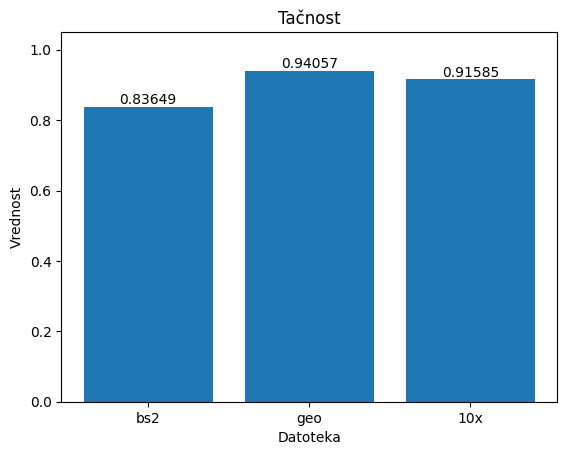

In [67]:
plot_accuracy(['bs2', 'geo', '10x'], [accuracy['bs2'][RF], accuracy['geo'][RF], accuracy['10x'][RF]])

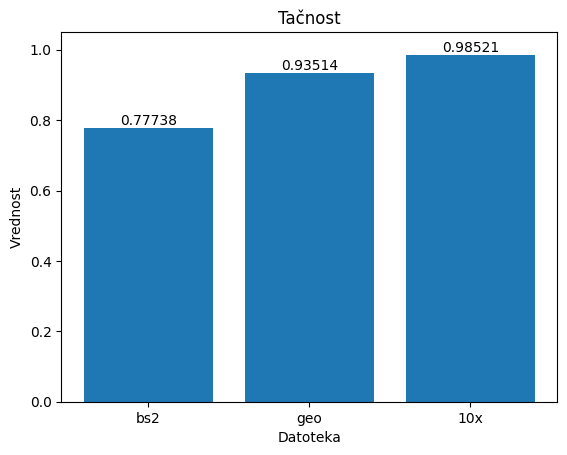

In [68]:
plot_accuracy(['bs2', 'geo', '10x'], [accuracy['bs2'][XGB], accuracy['geo'][XGB], accuracy['10x'][XGB]])

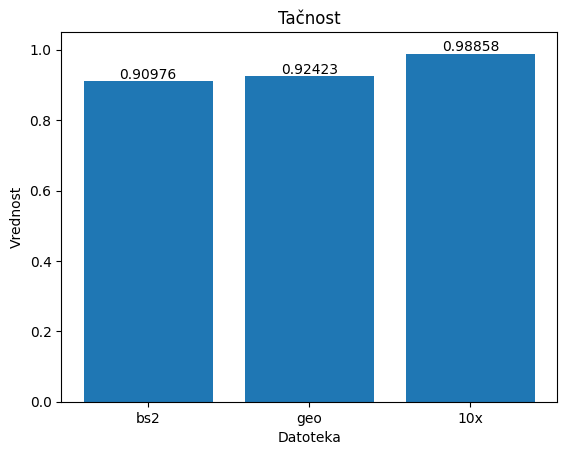

In [69]:
plot_accuracy(['bs2', 'geo', '10x'], [accuracy['bs2'][LR], accuracy['geo'][LR], accuracy['10x'][LR]])

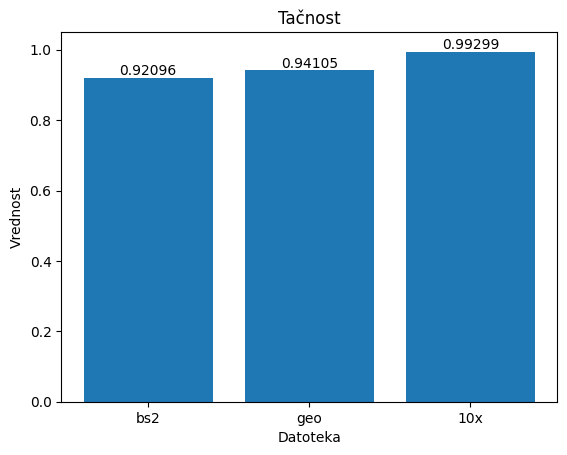

In [70]:
plot_accuracy(['bs2', 'geo', '10x'], [accuracy['bs2'][MLP], accuracy['geo'][MLP], accuracy['10x'][MLP]])

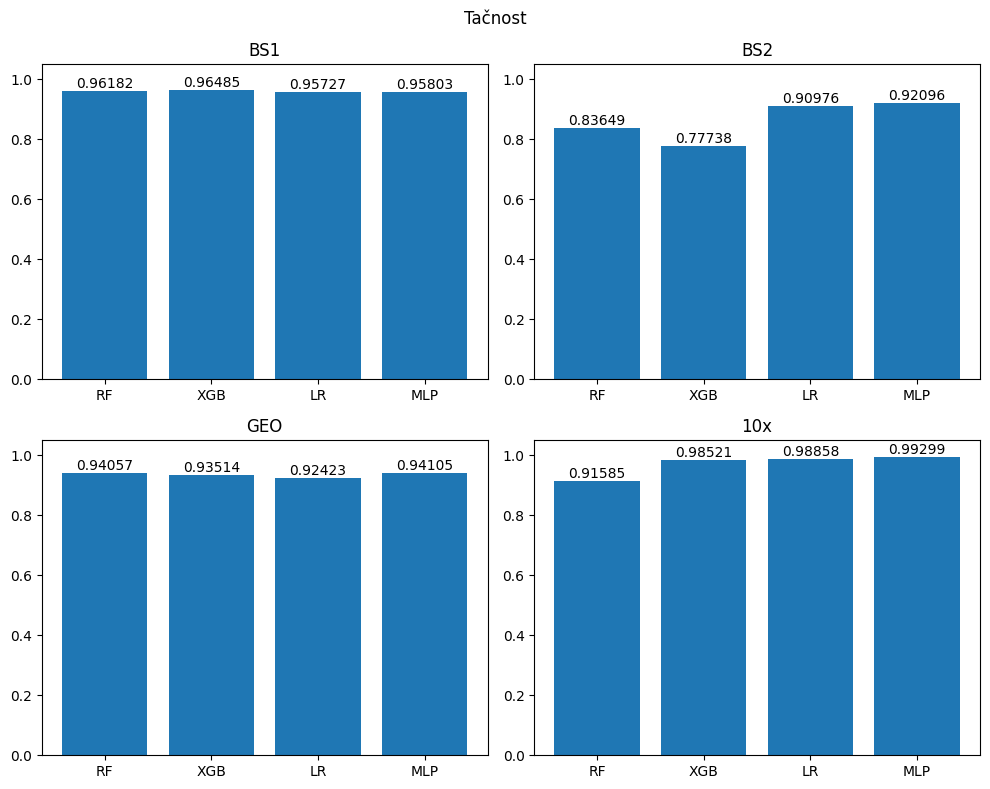

In [86]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Tačnost')

axs[0, 0].bar(models, accuracy['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(accuracy['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, accuracy['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(accuracy['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, accuracy['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(accuracy['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, accuracy['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(accuracy['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

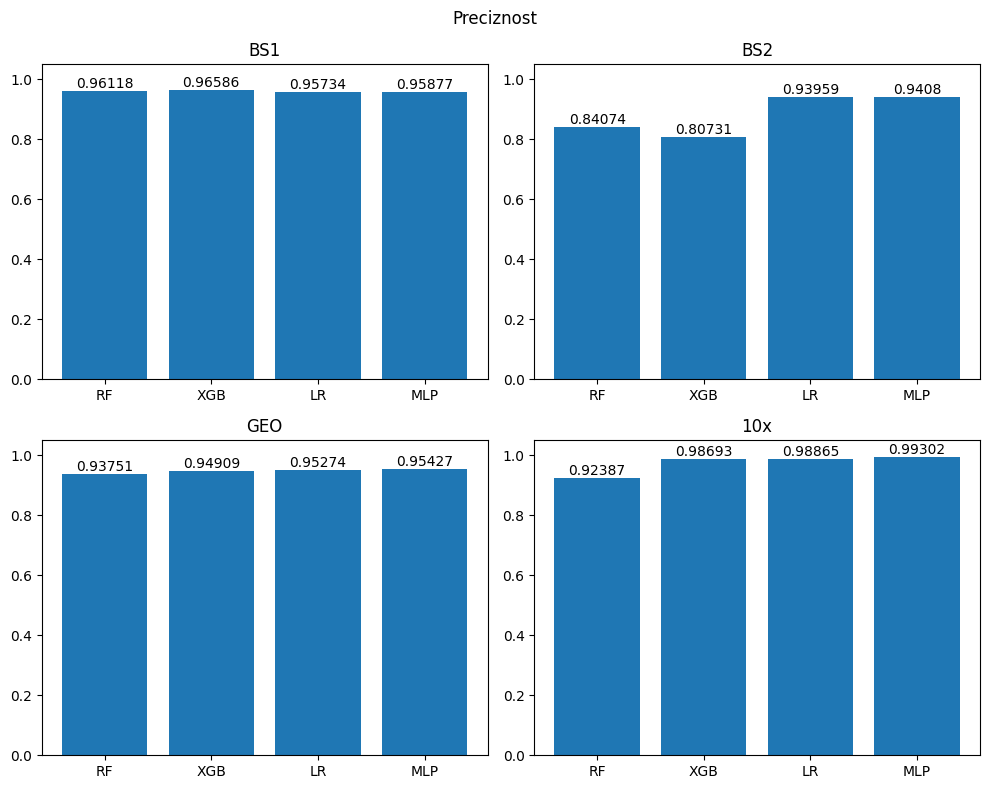

In [87]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Preciznost')

axs[0, 0].bar(models, precision['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(precision['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, precision['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(precision['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, precision['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(precision['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, precision['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(precision['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

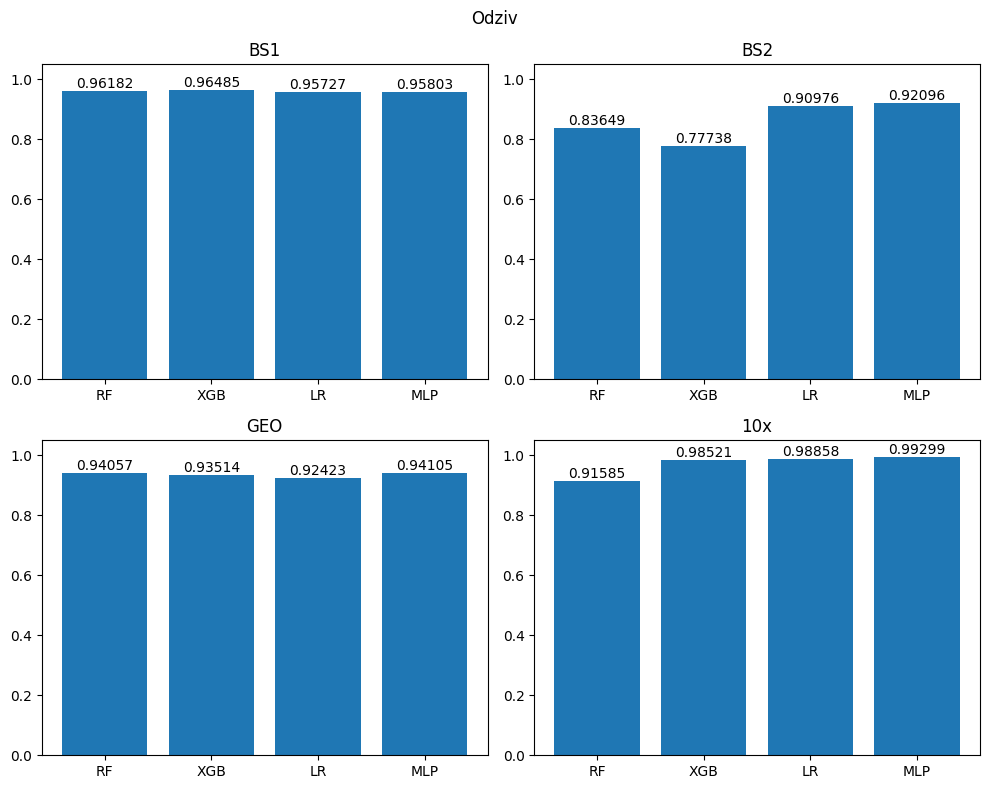

In [88]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Odziv')

axs[0, 0].bar(models, recall['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(recall['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, recall['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(recall['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, recall['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(recall['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, recall['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(recall['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

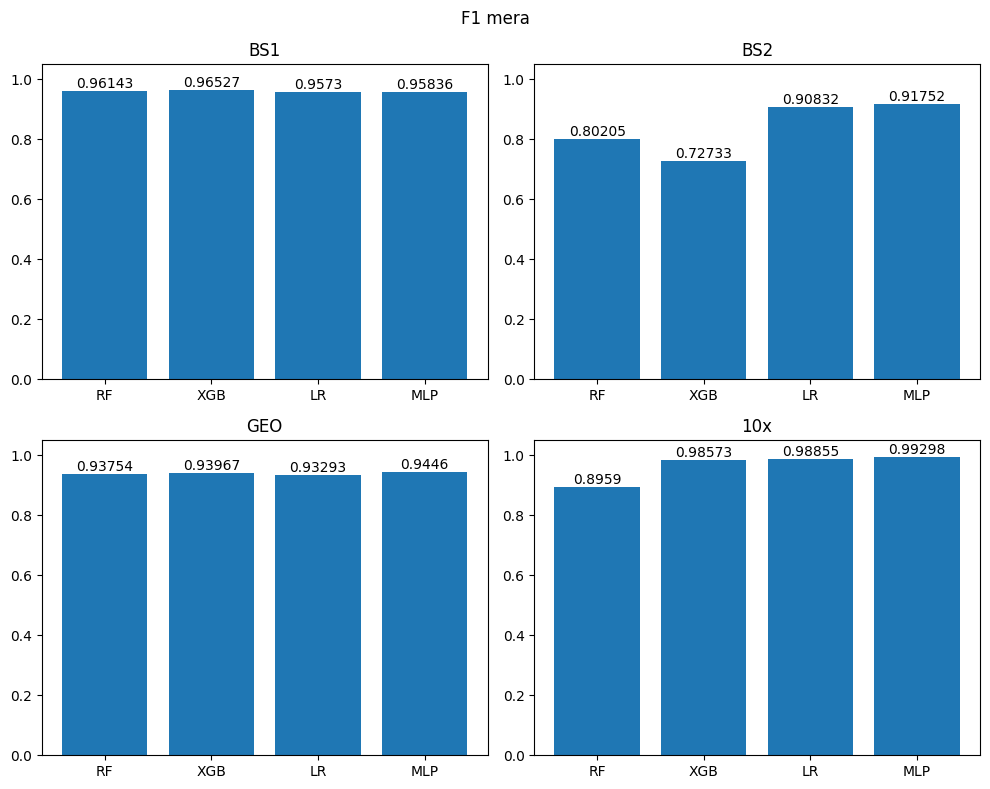

In [89]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('F1 mera')

axs[0, 0].bar(models, f1['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(f1['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, f1['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(f1['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, f1['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(f1['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, f1['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(f1['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

In [94]:
B = 0
D = 1
M = 2
NK = 3
T = 4

B_cells_accuracy = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

D_cells_accuracy = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

M_cells_accuracy = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

NK_cells_accuracy = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

T_cells_accuracy = {
    'bs1': [0, 0, 0, 0],
    'bs2': [0, 0, 0, 0],
    'geo': [0, 0, 0, 0],
    '10x': [0, 0, 0, 0]
}

In [117]:
def evaluate_cells(data_name, model_name):
    cm = cms[data_name][model_name]
    if len(cm) == 5:
        cells_accuracy = cm.diagonal() / cm.sum(axis=1)
        B_cells_accuracy[data_name][model_name] = cells_accuracy[B]
        D_cells_accuracy[data_name][model_name] = cells_accuracy[D] if cells_accuracy[D] > 0 else 0
        M_cells_accuracy[data_name][model_name] = cells_accuracy[M]
        NK_cells_accuracy[data_name][model_name] = cells_accuracy[NK]
        T_cells_accuracy[data_name][model_name] = cells_accuracy[T]
    else:
        cells_accuracy = cm.diagonal() / cm.sum(axis=1)
        B_cells_accuracy[data_name][model_name] = cells_accuracy[0]
        D_cells_accuracy[data_name][model_name] = 0
        M_cells_accuracy[data_name][model_name] = cells_accuracy[1]
        NK_cells_accuracy[data_name][model_name] = cells_accuracy[2]
        T_cells_accuracy[data_name][model_name] = cells_accuracy[3]


evaluate_cells('bs1', RF)
evaluate_cells('bs1', XGB)
evaluate_cells('bs1', LR)
evaluate_cells('bs1', MLP)

evaluate_cells('bs2', RF)
evaluate_cells('bs2', XGB)
evaluate_cells('bs2', LR)
evaluate_cells('bs2', MLP)

evaluate_cells('geo', RF)
evaluate_cells('geo', XGB)
evaluate_cells('geo', LR)
evaluate_cells('geo', MLP)

evaluate_cells('10x', RF)
evaluate_cells('10x', XGB)
evaluate_cells('10x', LR)
evaluate_cells('10x', MLP)

print(B_cells_accuracy)
print(D_cells_accuracy)
print(M_cells_accuracy)
print(NK_cells_accuracy)
print(T_cells_accuracy)

{'bs1': [0.9961389961389961, 0.9961389961389961, 0.9845559845559846, 0.9864864864864865], 'bs2': [0.8854555141182738, 0.8966435801811401, 0.988279168886521, 0.9914757591901971], 'geo': [0.7739179954441914, 0.7750569476082004, 0.7323462414578588, 0.7665148063781321], '10x': [0.9415938303341902, 0.9945501285347044, 0.9708997429305912, 0.9923907455012854]}
{'bs1': [0.8780487804878049, 1.0, 0.9024390243902439, 0.926829268292683], 'bs2': [0, 0.12222222222222222, 0.03333333333333333, 0.05555555555555555], 'geo': [0, 0, 0, 0], '10x': [0, 0, 0, 0]}
{'bs1': [0.9919354838709677, 0.9939516129032258, 0.9838709677419355, 0.9939516129032258], 'bs2': [0.6261216350947159, 0.27367896311066797, 1.0, 1.0], 'geo': [0.977803738317757, 0.955607476635514, 0.9824766355140186, 0.9813084112149533], '10x': [0.8668831168831169, 0.8630952380952381, 0.9107142857142857, 0.933982683982684]}
{'bs1': [0.798469387755102, 0.8622448979591837, 0.8137755102040817, 0.826530612244898], 'bs2': [0.11520190023752969, 0.104513064

C:\Users\bogda\AppData\Local\Temp\ipykernel_5568\1109830614.py:4: RuntimeWarning: invalid value encountered in divide
  cells_accuracy = cm.diagonal() / cm.sum(axis=1)


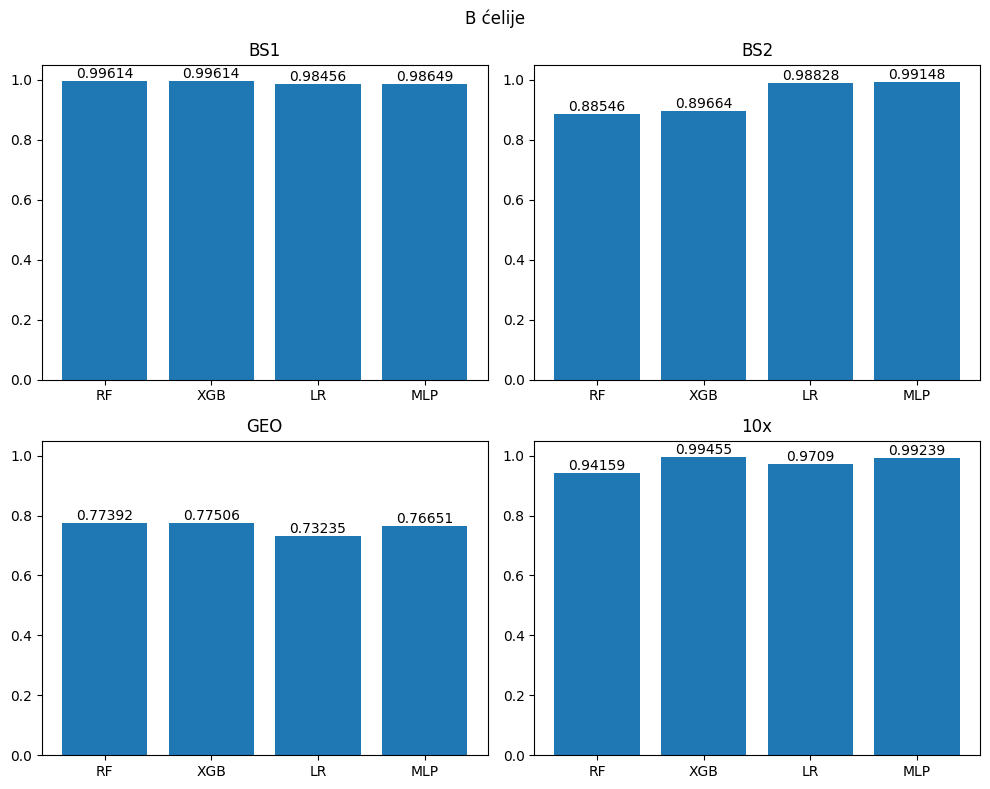

In [118]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('B ćelije')

axs[0, 0].bar(models, B_cells_accuracy['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(B_cells_accuracy['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, B_cells_accuracy['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(B_cells_accuracy['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, B_cells_accuracy['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(B_cells_accuracy['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, B_cells_accuracy['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(B_cells_accuracy['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

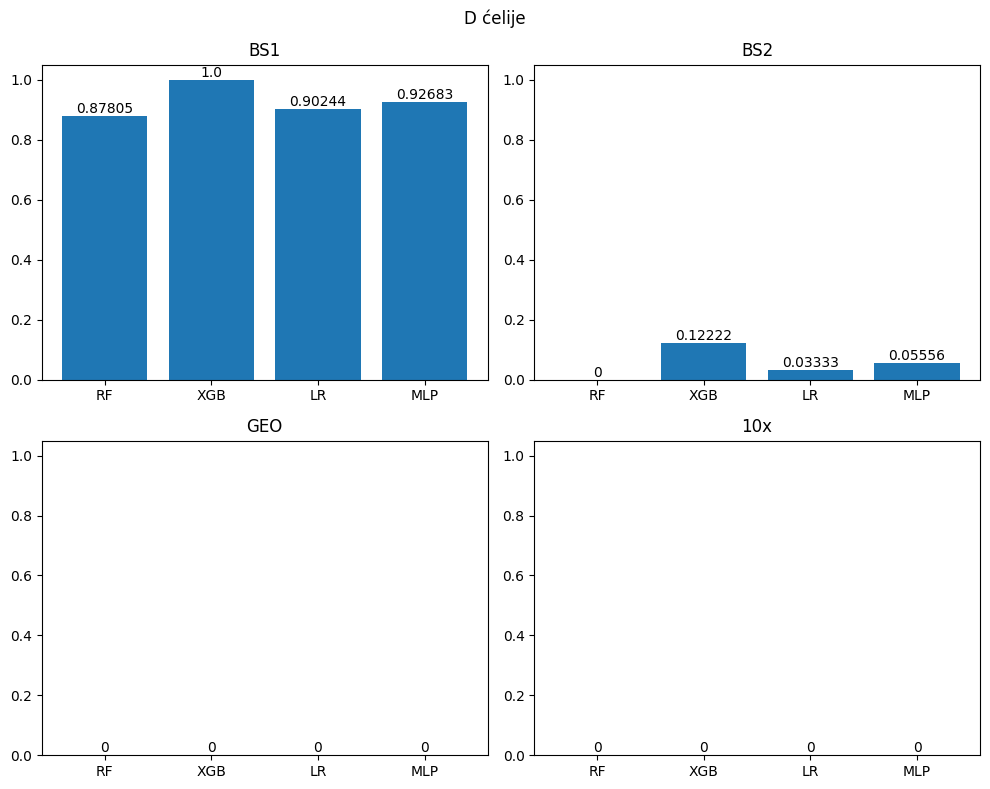

In [119]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('D ćelije')

axs[0, 0].bar(models, D_cells_accuracy['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(D_cells_accuracy['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, D_cells_accuracy['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(D_cells_accuracy['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, D_cells_accuracy['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(D_cells_accuracy['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, D_cells_accuracy['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(D_cells_accuracy['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

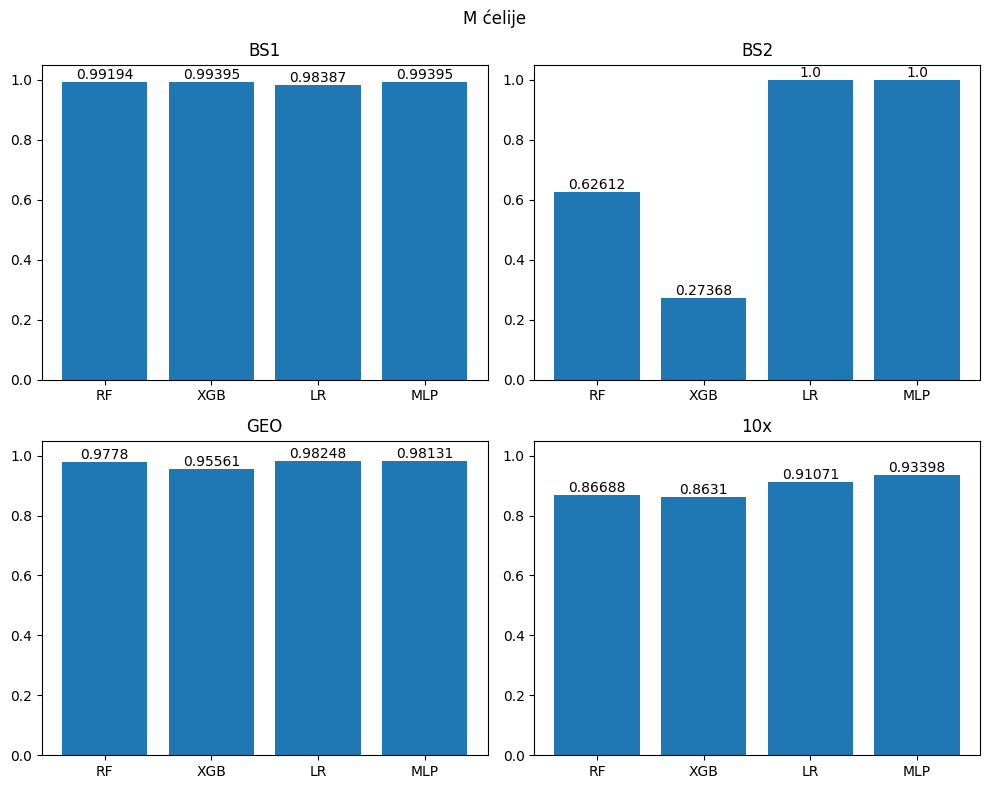

In [120]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('M ćelije')

axs[0, 0].bar(models, M_cells_accuracy['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(M_cells_accuracy['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, M_cells_accuracy['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(M_cells_accuracy['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, M_cells_accuracy['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(M_cells_accuracy['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, M_cells_accuracy['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(M_cells_accuracy['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

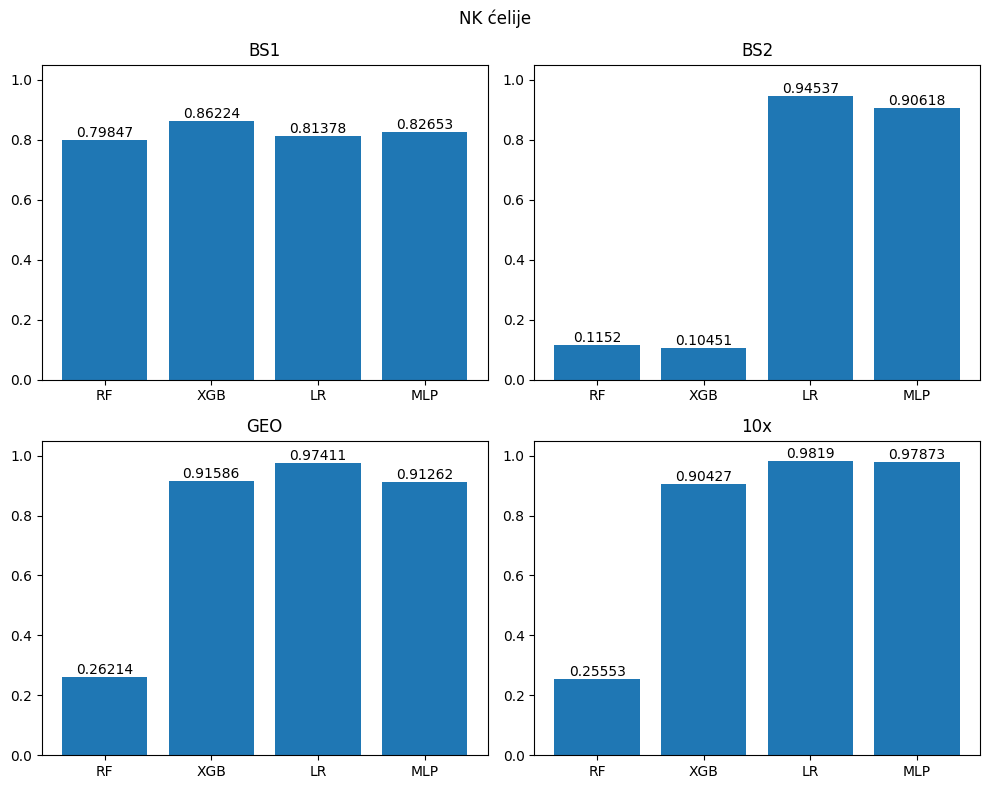

In [121]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('NK ćelije')

axs[0, 0].bar(models, NK_cells_accuracy['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(NK_cells_accuracy['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, NK_cells_accuracy['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(NK_cells_accuracy['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, NK_cells_accuracy['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(NK_cells_accuracy['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, NK_cells_accuracy['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(NK_cells_accuracy['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()

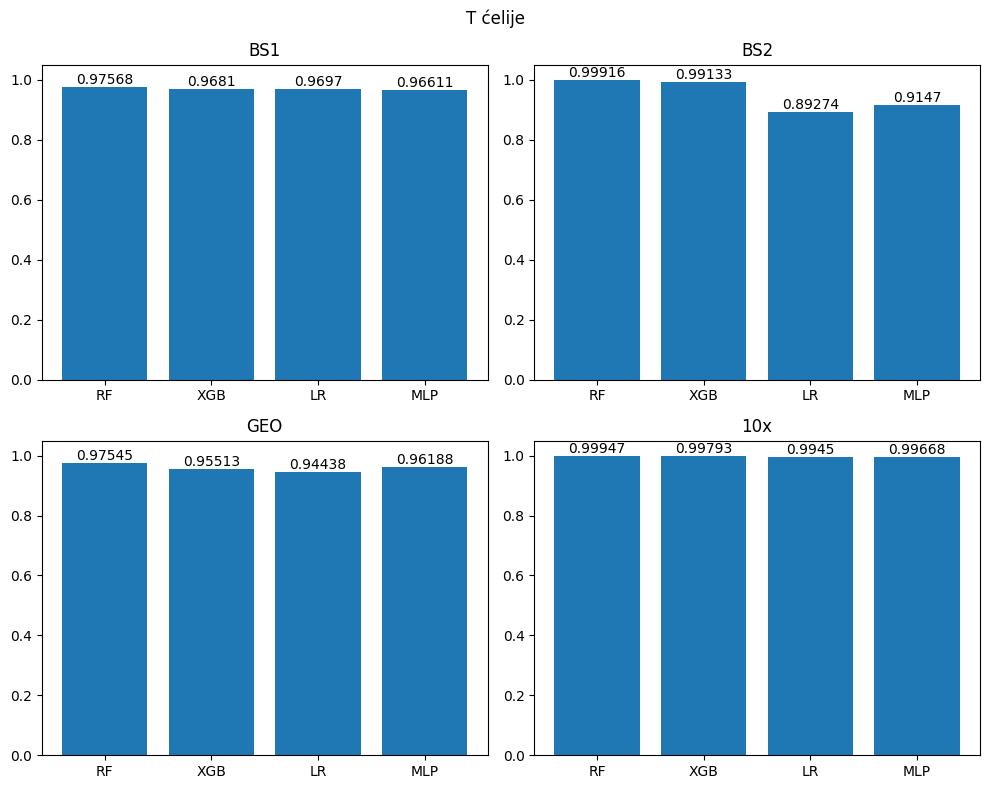

In [122]:
models = ['RF', 'XGB', 'LR', 'MLP']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('T ćelije')

axs[0, 0].bar(models, T_cells_accuracy['bs1'])
axs[0, 0].set_title('BS1')
for i, score in enumerate(T_cells_accuracy['bs1']):
    axs[0, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 0].set_ylim(0, 1.05)

axs[0, 1].bar(models, T_cells_accuracy['bs2'])
axs[0, 1].set_title('BS2')
for i, score in enumerate(T_cells_accuracy['bs2']):
    axs[0, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[0, 1].set_ylim(0, 1.05)

axs[1, 0].bar(models, T_cells_accuracy['geo'])
axs[1, 0].set_title('GEO')
for i, score in enumerate(T_cells_accuracy['geo']):
    axs[1, 0].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 0].set_ylim(0, 1.05)

axs[1, 1].bar(models, T_cells_accuracy['10x'])
axs[1, 1].set_title('10x')
for i, score in enumerate(T_cells_accuracy['10x']):
    axs[1, 1].text(i, score, str(round(score, 5)), ha='center', va='bottom')
axs[1, 1].set_ylim(0, 1.05)

plt.tight_layout()

plt.show()